Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
from sklearn.ensemble import GradientBoostingRegressor

# 4. Метрики качества
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [103]:
class DataPreprocessing :
   
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.total_LSquare_min_value = None
        self.total_RSmean_value = None
        self.total_LSquare_max_value = None
        self.total_LS_med_value = None
        self.total_RLSS_min_value = None
        self.district_size = None
        self.med_price_by_district = None
        self.numbers_to_str = {1:'A', 2:'B', 3:'C', 4:'D', 5:'E'}
        
     
    def fit_transform(self, df):
        """Трансформация данных и заполнение параметров"""
        # заменяем год со значением больше 2020 на 2020
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        # очищаем 'Healthcare_1' присваивая 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = 0
        # предполагаем, что квартир без комнат не бывает. Заменяем на 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        # предполагаем, что нулевой этаж это ошибка. Заменяем на 1
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = 1
        # добавляем фичу 'RatioSquare' - отношение жилой площади к общей. Находим среднее значение этой фичи.
        tmp = df[np.isfinite(df['LifeSquare'])]
        tmp['RatioSquare'] = tmp.LifeSquare/tmp.Square
        self.total_RSmean_value = tmp['RatioSquare'].mean()
        # корректируем выбросы со значениями общей площади меньше 15 и больше 400 
        df.loc[(df['Square'] < 15) | (df['Square'] > 390), 'Square'] = 34
        # очищаем 'LifeSquare', присваивая среднее
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df.Square * self.total_RSmean_value
        # исправляем некорректные значения жилой площади с учетом того, что жилая площадь не может быть больше общей
        df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df['Square']
        # заполняем вспомогательные фичи
        self.total_LSquare_min_value = np.quantile(df['LifeSquare'], q=0.4)
        self.total_LSquare_max_value = np.quantile(df['LifeSquare'], q=0.6)
        tmp = df.loc[(df['LifeSquare'] > self.total_LSquare_min_value) & (df['LifeSquare'] < self.total_LSquare_max_value)]
        tmp['LS'] = tmp.LifeSquare/tmp.Square
        self.total_LS_med_value = tmp['LS'].mean()
        # исправляем некорректные значения жилой площади с учетом того, что жилая площадь не может быть меньше 15
        df.loc[df['LifeSquare'] < 15, 'LifeSquare'] = df['Square'] * self.total_LS_med_value
        # заполняем вспомогательные фичи
        df['RatioLSS'] = df['LifeSquare']/df['Square']
        self.total_RLSS_min_value = np.quantile(df['RatioLSS'], q=0.25)
        # исправляем выбросы значения жилой площади в меньшую сторону
        df.loc[df['RatioLSS'] < self.total_RLSS_min_value, 'LifeSquare'] = df['Square'] * self.total_RLSS_min_value
        # предполагаем, что если площадь кухни равна 1 и количество комнат равно 1 кухни нет вообще (площадь кухни равна 0)
        df.loc[(df['Rooms'] == 1) & (df['KitchenSquare'] == 1), 'KitchenSquare'] = 0
        # в остальных случаях создаём фичу 'RatioLSK', которая показывает отношение площади кухни к жилой площади
        df['RatioLSK'] = df['KitchenSquare']/df['LifeSquare']
        # корректируем выбросы для площади кухни с учетом возраста дома (считаем , что в старых домах площадь кухни меньше)
        df.loc[(df['Rooms'] > 1) & (df['KitchenSquare'] < 5) & (df['HouseYear'] < 2000) , 'KitchenSquare'] = df['LifeSquare'] * 0.25
        df.loc[(df['Rooms'] > 1) & (df['KitchenSquare'] < 5) & (df['HouseYear'] > 1999) , 'KitchenSquare'] = df['LifeSquare'] * 0.3
        # площадь кухни не может быть больше жилой площади
        df.loc[df['KitchenSquare'] > df['LifeSquare'], 'KitchenSquare'] = df['LifeSquare'] * 0.25
        df['RatioLSK'] = df['KitchenSquare']/df['LifeSquare']
        df.loc[df['RatioLSK'] > 0.9, 'KitchenSquare'] = df['LifeSquare'] * 0.3
        # разберёмся с комнатами
        df.loc[df['Rooms'] > 5, 'Rooms'] = 1
        df['RatioLFR'] = (df['LifeSquare']-df['KitchenSquare'])/df['Rooms']
        df.loc[df['RatioLFR'] < 7, 'Rooms'] = round((df['LifeSquare'] - df['KitchenSquare']) / 7)
        # добавляем фичи для модели
        self.district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = df.merge(self.district_size, on='DistrictId', how='left')
        df['PriceSquare']= df.Price/df.Square
        self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'PriceSquare':'median'})\
                    .rename(columns={'index':'DistrictId', 'PriceSquare':'MedPriceByDistrict'})
        df = df.merge(self.med_price_by_district, on=['DistrictId'], how='left')
        #преобразуем Rooms из числового признака в категорию
        df['Rooms'] = df['Rooms'].replace(self.numbers_to_str)
        # преобразование нечисловых признаков
        df = pd.get_dummies(df)
        return df
    
    def transform(self, df):
        """Трансформация данных"""
        # заменяем год со значением больше 2020 на 2020
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        # очищаем 'Healthcare_1' присваивая 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = 0
        # предполагаем, что квартир без комнат не бывает. Заменяем на 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        # предполагаем, что нулевой этаж это ошибка. Заменяем на 1
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = 1
        # корректируем выбросы со значениями общей площади меньше 15 и больше 400 
        df.loc[(df['Square'] < 15) | (df['Square'] > 390), 'Square'] = 34
        # очищаем 'LifeSquare', присваивая среднее
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df.Square * self.total_RSmean_value
        # исправляем некорректные значения жилой площади с учетом того, что жилая площадь не может быть больше общей
        df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df['Square']
        # исправляем некорректные значения жилой площади с учетом того, что жилая площадь не может быть меньше 15
        df.loc[df['LifeSquare'] < 15, 'LifeSquare'] = df['Square'] * self.total_LS_med_value
        # исправляем выбросы значения жилой площади в меньшую сторону
        df['RatioLSS'] = df['LifeSquare']/df['Square']
        df.loc[df['RatioLSS'] < self.total_RLSS_min_value, 'LifeSquare'] = df['Square'] * self.total_RLSS_min_value
        # предполагаем, что если площадь кухни равна 1 и количество комнат равно 1 кухни нет вообще (площадь кухни равна 0)
        df.loc[(df['Rooms'] == 1) & (df['KitchenSquare'] == 1), 'KitchenSquare'] = 0
        # в остальных случаях создаём фичу 'RatioLSK', которая показывает отношение площади кухни к жилой площади
        df['RatioLSK'] = df['KitchenSquare']/df['LifeSquare']
        # корректируем выбросы для площади кухни с учетом возраста дома (считаем , что в старых домах площадь кухни меньше)
        df.loc[(df['Rooms'] > 1) & (df['KitchenSquare'] < 5) & (df['HouseYear'] < 2000) , 'KitchenSquare'] = df['LifeSquare'] * 0.25
        df.loc[(df['Rooms'] > 1) & (df['KitchenSquare'] < 5) & (df['HouseYear'] > 1999) , 'KitchenSquare'] = df['LifeSquare'] * 0.3
        # площадь кухни не может быть больше жилой площади
        df.loc[df['KitchenSquare'] > df['LifeSquare'], 'KitchenSquare'] = df['LifeSquare'] * 0.25
        df['RatioLSK'] = df['KitchenSquare']/df['LifeSquare']
        df.loc[df['RatioLSK'] > 0.9, 'KitchenSquare'] = df['LifeSquare'] * 0.3
        # разберёмся с комнатами
        df.loc[df['Rooms'] > 5, 'Rooms'] = 1
        df['RatioLFR'] = (df['LifeSquare']-df['KitchenSquare'])/df['Rooms']
        df.loc[df['RatioLFR'] < 7, 'Rooms'] = round((df['LifeSquare'] - df['KitchenSquare']) / 7)
        # добавляем фичи для модели
        df = df.merge(self.med_price_by_district, on=['DistrictId'], how='left')
        # преобразуем Rooms из числового признака в категорию
        df['Rooms'] = df['Rooms'].replace(self.numbers_to_str)
        # убираем пропуски в тестовом датасете
        df.loc[df['MedPriceByDistrict'].isna(), 'MedPriceByDistrict'] = 4134
        # преобразование нечисловых признаков
        df = pd.get_dummies(df)
        return df

ПОСТРОЕНИЕ ML МОДЕЛИ

In [98]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')

In [120]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [122]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.000,36.848,19.094,5.000,5,9.000,1970,0.036,B,B,24,4378,0,1036.000,1,1,B
1,5925,62,1.000,42.494,42.568,10.000,7,17.000,2017,0.072,B,B,2,629,1,NaN,0,0,A
2,960,27,2.000,59.464,NaN,9.000,19,19.000,1977,0.211,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.000,49.646,33.894,6.000,2,2.000,1965,0.014,B,B,2,475,0,NaN,0,0,B
4,746,74,1.000,53.837,NaN,1.000,8,17.000,1977,0.309,B,B,35,7715,4,990.000,0,6,B


In [126]:
submit = test_df[['Id']].copy()

,Id
0,4567
1,5925
2,960
3,3848
4,746


In [101]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [104]:
preprocessor = DataPreprocessing()

In [105]:
train_df = preprocessor.fit_transform(train_df)

In [106]:
test_df = preprocessor.transform(test_df)

In [107]:
feature_names = [
 'Rooms_A',
 'Rooms_B',
 'Rooms_C',
 'Rooms_D',
 'Rooms_E',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'MedPriceByDistrict',                
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

target_name = 'Price'

In [108]:
train_df = train_df[feature_names + [target_name]]

In [109]:
test_df = test_df[feature_names ]

In [110]:
X = train_df[feature_names]
y = train_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [111]:
final_model = GradientBoostingRegressor(criterion='squared_error',
                                        max_depth=4,
                                        min_samples_leaf=5,
                                        learning_rate=0.05,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.05,
                          max_depth=4, min_samples_leaf=5, n_estimators=400,
                          random_state=42)

R2:	0.844
RMSE:	36332.562
MSE:	1320055096.822


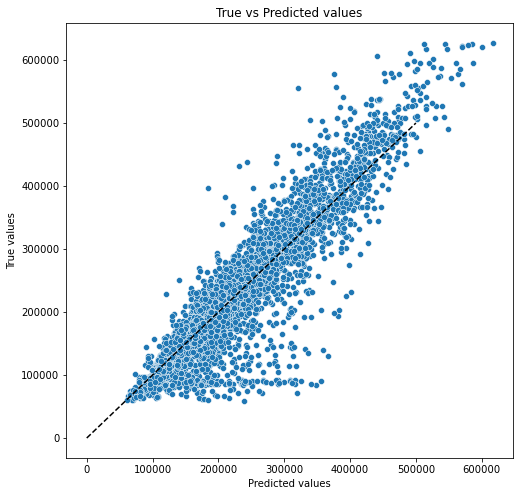

In [112]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.749
RMSE:	47844.002
MSE:	2289048537.068


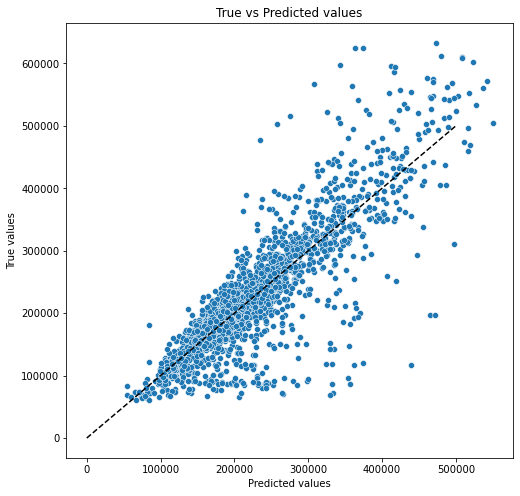

In [113]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=False)

In [114]:
predictions = final_model.predict(test_df)

In [127]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,169068.909
1,5925,123800.175
2,960,144698.292
3,3848,106603.290
4,746,173624.817


In [129]:
submit.to_csv('rf_submit.csv', index=False)